In [246]:
import os
import glob
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import argparse

import torch
import torchvision
from torch.utils.data import Dataset
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import utils
from engine import train_one_epoch, evaluate
import transforms as T

In [247]:
imgs_dir = "../RiceDiseaseDataset/images/"
labels_dir = "../RiceDiseaseDataset/labels/"

In [258]:
class RiceDiseaseDataset(Dataset):
    """Builds a dataset with image and their labels.
    
    
    """
    
    def __init__(self, imgs_dir, labels_dir, transforms=None):
        """
        
        Args:
            
        """
        self.imgs_dir = imgs_dir
        self.labels_dir = labels_dir
        self.imgs = list(sorted(os.listdir(self.imgs_dir)))
        self.xml_df = self.xml_to_csv(self.labels_dir)
        self.class_names = self.xml_df["class"].unique()
        self.labels_dict = self.create_labels_dict(self.xml_df)
        self.transforms = transforms
        
    
    def __len__(self):
        """
        """
        return len(self.imgs)
    
    def __getitem__(self, idx):
        """
        """
        img_name = self.imgs[idx]
        img_path = os.path.join(self.imgs_dir, img_name)
        img = cv.imread(img_path)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        
        img_df = self.xml_df[self.xml_df["filename"] == img_name]
        boxes = img_df[["xmin", "ymin", "xmax", "ymax"]].values
        labels = img_df[["class"]].values


        # change this
        classes = []
        for key, value in self.labels_dict.items():
            for i in labels:
                if i == value:
                    classes.append(key)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(classes, dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.tensor(classes, dtype=torch.int64)
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def create_labels_dict(self, xml_df):
        labels = self.class_names
        labels_dict = {}
        for index, label in enumerate(labels):
            labels_dict.__setitem__(index, label)
            
        return labels_dict
    
    def get_box_class(self, xml_df, img_name):
        labels = self.xml_df[self.xml_df["filename"] == img_name]
        return labels
    
    def xml_to_csv(self, path):
        # parses xml files and adds results to Pandas DataFrame 
        xml_list = []
        for xml_file in glob.glob(path + '/*.xml'):
            tree = ET.parse(xml_file)
            root = tree.getroot()
            for child in root.findall('object'):
                value = (root.find('filename').text,
                        int(root.find('size')[0].text),
                        int(root.find('size')[1].text),
                        child[0].text,
                        int(child[4][0].text),
                        int(child[4][1].text),
                        int(child[4][2].text),
                        int(child[4][3].text)
                        )
                xml_list.append(value)
        column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
        xml_df = pd.DataFrame(xml_list, columns=column_name)
        xml_df.to_csv("../RiceDiseaseDataset/labels.csv")
        return xml_df

In [259]:
sample = RiceDiseaseDataset(imgs_dir, labels_dir)
sample[1]

(array([[[154, 148, 150],
         [ 93,  88,  92],
         [ 71,  69,  71],
         ...,
         [186, 154, 157],
         [185, 153, 156],
         [184, 152, 155]],
 
        [[142, 140, 141],
         [ 79,  76,  77],
         [ 57,  57,  54],
         ...,
         [187, 155, 158],
         [185, 153, 156],
         [184, 152, 155]],
 
        [[133, 133, 132],
         [ 65,  66,  61],
         [ 47,  49,  41],
         ...,
         [188, 156, 159],
         [185, 153, 156],
         [184, 152, 155]],
 
        ...,
 
        [[234, 243, 235],
         [237, 244, 239],
         [241, 248, 243],
         ...,
         [138, 183,  79],
         [137, 182,  75],
         [136, 182,  74]],
 
        [[219, 237, 211],
         [215, 234, 213],
         [220, 237, 220],
         ...,
         [139, 183,  85],
         [139, 184,  82],
         [138, 184,  80]],
 
        [[203, 230, 170],
         [186, 220, 158],
         [188, 219, 171],
         ...,
         [140, 184,  94],
  

In [260]:
sample.labels_dict

{0: 'Bacterial_Blight', 1: 'Rice_Blast', 2: 'Brown_Spot'}

In [261]:
def get_model(num_classes=3):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [262]:
def get_transforms(train):
    transforms = []
    transforms.append(T.ToTensor())

    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [263]:
# Hyperparameters
test_set_length = 100 		 # Test set (number of images)
train_batch_size = 2  		 # Train batch size
test_batch_size = 1    		 # Test batch size
num_classes = 3        		 # Number of classes
learning_rate = 0.005	 # Learning rate
num_epochs = 10     	     # Number of epochs
output_dir = "saved_model"   # Output directory to save the model

In [264]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

dataset = RiceDiseaseDataset(imgs_dir, labels_dir, transforms=get_transforms(train=True))
dataset_test = RiceDiseaseDataset(imgs_dir, labels_dir, transforms=get_transforms(train=False))

torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-test_set_length])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-test_set_length:])

data_loader = torch.utils.data.DataLoader(dataset, batch_size=train_batch_size, 
                    shuffle=True, num_workers=0, collate_fn=utils.collate_fn)
data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=test_batch_size,
                    shuffle=False, num_workers=0, collate_fn=utils.collate_fn)
print("Dataset Details\nImages: {}, Train: {}, Test: {}.\n".format(len(indices),
                                len(dataset), len(dataset_test)))

Dataset Details
Images: 551, Train: 451, Test: 100.



tensor([2, 2, 2])


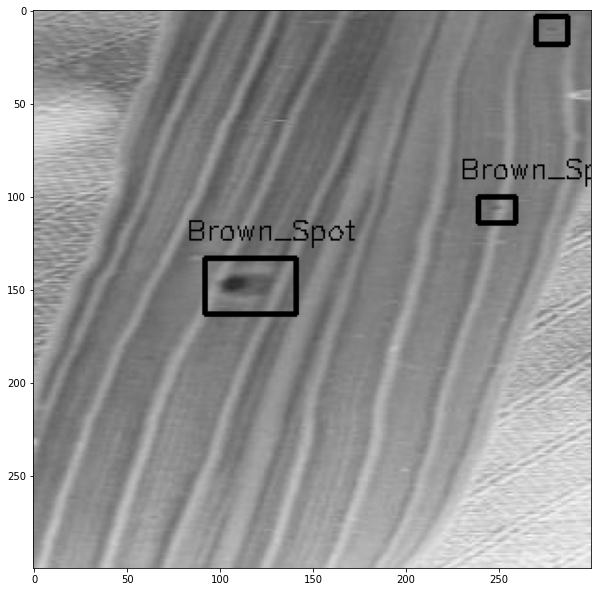

In [266]:
dataiter = iter(data_loader)
images, targets = dataiter.next()


# plot the images in the batch, along with predicted labels
fig = plt.figure(figsize=(10, 40))
for idx in np.arange(20):
#     ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    img = images[idx]
    target = targets[idx]
    img = img.cpu()
    img = np.transpose(img, (1, 2, 0))
    img = cv.cvtColor(np.float32(img), cv.COLOR_RGB2GRAY)
    boxes = target["boxes"]
    labels = target["labels"]
    print(labels)
    for box, label in zip(boxes, labels):
        x = int(box[0].item())
        y = int(box[1].item())
        w = int(box[2].item())
        h = int(box[3].item())
#         x,y,w,h = int(box[0].item()), int(box[1].item()), int(box[2].item(), int(box[3].item())
        cv.rectangle(img, (x, y), (w, h), (0,0,255), 2)
        label = str(sample.labels_dict[label.item()])
        cv.putText(img, label, (x-10,y-10), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
# 	cv.putText(image, text, (x, y), cv.FONT_HERSHEY_SIMPLEX, 0.5,
# 					 (255, 255, 255), 1)
    plt.imshow(img, cmap="gray")
    plt.show()
    break

In [267]:
model = get_model(num_classes=3)
model.to(device=device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr = learning_rate, momentum = 0.9, weight_decay = 0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 3, gamma = 0.1)

In [ ]:
for epoch in range(1):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    lr_scheduler.step()
    evaluate(model, data_loader_test, device=device)

if not os.path.exists(output_dir):
    os.mkdir(output_dir)

torch.save(model.state_dict(), output_dir + "/model")

Epoch: [0]  [  0/226]  eta: 0:16:24  lr: 0.000027  loss: 0.2701 (0.2701)  loss_classifier: 0.1408 (0.1408)  loss_box_reg: 0.0159 (0.0159)  loss_objectness: 0.0939 (0.0939)  loss_rpn_box_reg: 0.0195 (0.0195)  time: 4.3563  data: 0.0149  max mem: 2301
Epoch: [0]  [ 10/226]  eta: 0:12:50  lr: 0.000249  loss: 0.9895 (1.4065)  loss_classifier: 0.6154 (0.6545)  loss_box_reg: 0.0971 (0.0959)  loss_objectness: 0.2879 (0.6146)  loss_rpn_box_reg: 0.0289 (0.0415)  time: 3.5685  data: 0.0157  max mem: 2621
Epoch: [0]  [ 20/226]  eta: 0:12:08  lr: 0.000471  loss: 0.5988 (0.9592)  loss_classifier: 0.3852 (0.4917)  loss_box_reg: 0.0755 (0.0774)  loss_objectness: 0.1245 (0.3608)  loss_rpn_box_reg: 0.0209 (0.0292)  time: 3.4962  data: 0.0191  max mem: 2621
Epoch: [0]  [ 30/226]  eta: 0:11:34  lr: 0.000693  loss: 0.2880 (0.7536)  loss_classifier: 0.1645 (0.3848)  loss_box_reg: 0.0498 (0.0767)  loss_objectness: 0.0568 (0.2650)  loss_rpn_box_reg: 0.0163 (0.0272)  time: 3.5274  data: 0.0224  max mem: 2621
